TVD (ideal vs noisy): 0.06640625
KL Divergence: 0.026386234079286724


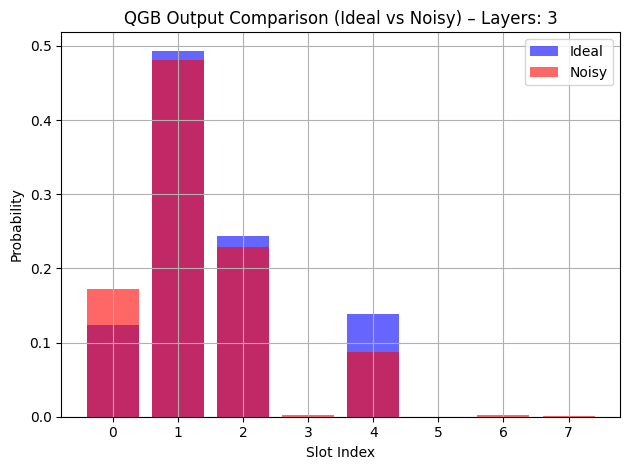

In [1]:
# noise_vs_ideal.ipynb

from circuits.quantum_peg_multi import run_qgb, postprocess_qgb
from metrics.distance_metrics_multi import total_variation_distance, kl_divergence
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. Create noise model
noise_model = NoiseModel()
p1, p2, p3 = 0.001, 0.01, 0.02

noise_model.add_all_qubit_quantum_error(depolarizing_error(p1, 1), ['x', 'h', 'rx'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ['cx'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(p3, 3), ['cswap', 'ccx'])

readout = ReadoutError([[0.98, 0.02], [0.02, 0.98]])
noise_model.add_all_qubit_readout_error(readout)


sim_noisy = AerSimulator(noise_model=noise_model)

# 2. Compare ideal vs noisy QGB
layers = 3
ideal_qc, ideal_counts = run_qgb(layers, theta=np.pi/2)
ideal_dist = postprocess_qgb(ideal_counts)

compiled_noisy = ideal_qc.copy()
compiled_noisy = compiled_noisy.decompose()
job = sim_noisy.run(compiled_noisy, shots=1024)
noisy_counts = job.result().get_counts()
noisy_dist = postprocess_qgb(noisy_counts)

# 3. Distance metrics
print("TVD (ideal vs noisy):", total_variation_distance(ideal_dist, noisy_dist))
print("KL Divergence:", kl_divergence(ideal_dist, noisy_dist))


# 4. Plot and compare ideal vs noisy distributions
os.makedirs("results", exist_ok=True)

plt.bar(ideal_dist.keys(), ideal_dist.values(), alpha=0.6, label="Ideal", color='blue')
plt.bar(noisy_dist.keys(), noisy_dist.values(), alpha=0.6, label="Noisy", color='red')
plt.title(f"QGB Output Comparison (Ideal vs Noisy) – Layers: {layers}")
plt.xlabel("Slot Index")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/noisy_comparison.png") 
plt.show()